In [ ]:
#demo2

In [1]:
import base

In [2]:
from dataset.sig_dataset import SigDataModule

In [3]:
from model.sig_model import CVAE,MLP

In [4]:
import torch.nn as nn
import torch

In [5]:
from utils.leadlag import leadlag
from utils import tosig
import logsig_inversion

In [6]:
import numpy as np

In [ ]:
import time
from multiprocessing import  Manager,Pool


In [ ]:
import os
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag

In [7]:
model_path = 'EURUSD_21.ckpt'

In [8]:
input_dim = 8
condition_dim = 8
batch = 32

middle_dim = 50
hidden_dim = 8
common_network = nn.Sequential(
    nn.Linear(input_dim+ condition_dim,middle_dim),
    nn.LeakyReLU(0.3),
)
mean_network = nn.Sequential(
    nn.Linear(middle_dim,hidden_dim),
    nn.LeakyReLU(0.3),
)
logvar_network = nn.Sequential(
    nn.Linear(middle_dim,hidden_dim),
    nn.LeakyReLU(0.3),
)
decode_network = nn.Sequential(
    nn.Linear(hidden_dim+condition_dim,input_dim),
    nn.LeakyReLU(0.3),
    nn.Sigmoid(),
)
net = CVAE.load_from_checkpoint(model_path,common_network = common_network, 
                            mean_network=mean_network, 
                            logvar_network= logvar_network,
                            decode_network = decode_network,
                            optim=torch.optim.Adam,lr=0.005)

INFO:root:struct init
INFO:root:encoder_init_over
INFO:root:decoder_init_over
INFO:root:optim_init_over
INFO:root:struct init_over


In [9]:

dm = SigDataModule(path=os.path.join(base.data_path,'EURUSD.csv'),batch_size=32,level=4)
dm.prepare_data()

In [10]:
logsig = net.generate(dm.conditions[-1])
logsig = dm.minmax.inverse_transform(logsig.detach().numpy())

In [11]:
pip = 0.0001 #0.01
n_pips = 5 * 10000
n_points = 21#21

n_iterations = 100 #循环次数
n_organisms = 400 #生物  
level = 4
recovered_path, loss = logsig_inversion.train(logsig, level, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

  0%|          | 0/100 [00:00<?, ?it/s]

In [59]:
def concatenate(condition, periods):#periods 期 一单元是一个月 所以3期就是 3*1 = 3个月
    joined_path = None

    for _ in range(periods):
        generated = net.generate(condition)
        generated = dm.minmax.inverse_transform(generated.detach().numpy())
        path, loss = logsig_inversion.train(generated, level, n_iterations, n_organisms, n_points,#window
                                            pip, n_pips)

        condition = tosig.stream2logsig(leadlag(recovered_path), level)
        condition = dm.minmax.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]#!
            
    return joined_path

In [65]:
def worker(i,lst,condition,window_size):
    time1 = time.time()
    ## init random
    np.random.seed()
    
    ## code start ##
    path = concatenate(condition, 1)
    ## code end ##
    lst.append(path)
    time2 = time.time()
    print(f'user time {time2-time1}')


# with Manager() as manager:
def api(price,condition,batch_size=100,window_size=21,n_jobs=20):

    manager = Manager()
    lst = manager.list()
    pool = Pool(n_jobs)
    for i in range(batch_size):
        pool.apply_async(worker,(i,lst,condition,window_size))
    pool.close()
    pool.join()
    paths = np.array(lst)
    return price + np.transpose(paths)



In [ ]:
#第一天的价格  加上一个月的交易行为的signature

In [66]:
idx = 12 #从第几天开始模拟 找到当天对应的id

k = api(price=dm.windows[idx + 1][0, 0],condition=dm.conditions[idx],batch_size=40)

user time 29.682411909103394


  0%|          | 0/100 [00:00<?, ?it/s]

user time 29.893374919891357
user time 29.98157811164856
user time 29.99104356765747


  0%|          | 0/100 [00:00<?, ?it/s]

user time 30.060725927352905
user time 30.07569122314453


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

user time 30.256747007369995
user time 30.28893780708313


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

user time 30.43921732902527
user time 30.509505033493042


  0%|          | 0/100 [00:00<?, ?it/s]

user time 30.633490562438965


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

user time 30.831969022750854
user time 30.857691764831543
user time 30.91523289680481


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

user time 31.192365884780884


  0%|          | 0/100 [00:00<?, ?it/s]

user time 31.664406538009644


  0%|          | 0/100 [00:00<?, ?it/s]

user time 31.836860418319702


  0%|          | 0/100 [00:00<?, ?it/s]

user time 32.58410930633545
user time 32.625362157821655
user time 32.66574549674988


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

user time 30.241517066955566
user time 30.113094568252563
user time 30.11013436317444
user time 30.290276050567627
user time 30.02796483039856
user time 30.458405017852783
user time 30.48387598991394
user time 30.38101887702942
user time 30.33390522003174
user time 30.107546091079712
user time 30.07932162284851
user time 30.550402641296387
user time 30.83079171180725
user time 30.660475969314575
user time 30.202911376953125
user time 29.850253105163574
user time 30.042269706726074
user time 29.967144012451172
user time 32.108394622802734
user time 33.34806203842163


In [67]:
import matplotlib.pyplot as plt

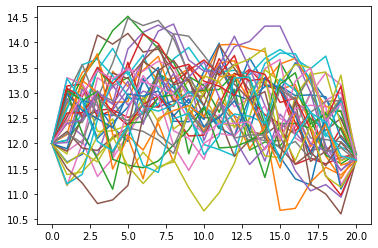

In [69]:
plt.plot(k)
plt.show()